<a href="https://colab.research.google.com/github/Jade-P/MLGroupProject/blob/Happy--Sohyun/CNN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment & path Setup 

In [1]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1fr1dJI9LyphQ6Y0Wo_au1ymvUsZnNvXD' 


download = drive.CreateFile({'id': file_id})


# Download the file to a local disc
download.GetContentFile('preprocessed.zip')

In [3]:
!unzip -qq preprocessed.zip

#Load Data

In [4]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
RANDOM_SEED = 123

In [5]:
TRAIN_DIR = ('Training/Training/')
TEST_DIR = ('Testing/Testing/')

In [6]:
emotions = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']

In [7]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(emotions)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file, cv2.IMREAD_GRAYSCALE)
                    img = img.astype('float32') / 255 # NORMALIZES PIXELS 
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [8]:
IMG_SIZE= (48, 48)

In [9]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


36854 images loaded from Training/Training/ directory.


In [10]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [11]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [00:00<00:00, 12.87it/s]


7067 images loaded from Testing/Testing/ directory.


In [12]:
X_train.shape

(36854, 48, 48)

#Model Building

In [13]:
# load libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

# NOTE: the pixels were already normalized from 0-1 values upon loading 

In [14]:
X_train.shape

(36854, 48, 48)

In [15]:
y_train

array([0, 0, 0, ..., 5, 5, 5])

In [16]:
y_test

array([0, 0, 0, ..., 5, 5, 5])

In [17]:
# Input image dimensions
img_rows, img_cols = 48, 48

# Channels go last for TensorFlow backend
X_train_reshaped = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# one hot encode y_train and y_test
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

y_train = enc.fit_transform(y_train.reshape(-1, 1))

y_test = enc.fit_transform(y_test.reshape(-1, 1))

y_train = y_train.toarray()
y_test = y_test.toarray()

In [18]:
y_train

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [19]:
y_test

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [20]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [21]:
y_train

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [48]:
# our further customized model:
modelc = Sequential()

modelc.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1), data_format='channels_last'))
modelc.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelc.add(Dropout(0.6))

modelc.add(Conv2D(2*64, kernel_size=(3, 3), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(Conv2D(2*64, kernel_size=(3, 3), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(Conv2D(2*64, kernel_size=(3, 3), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelc.add(Dropout(0.6))

modelc.add(Conv2D(2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(Conv2D(2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelc.add(Dropout(0.5))

modelc.add(Conv2D(2*2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(Conv2D(2*2*2*64, kernel_size=(3, 3), activation='relu', padding='same'))
modelc.add(BatchNormalization())
modelc.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
modelc.add(Dropout(0.6))

modelc.add(Flatten())

modelc.add(Dense(2*2*2*64, activation='relu'))
modelc.add(Dropout(0.4))
modelc.add(Dense(2*2*64, activation='relu'))
modelc.add(Dropout(0.4))
modelc.add(Dense(2*64, activation='relu'))
modelc.add(Dropout(0.5))

modelc.add(Dense(6, activation='softmax')) # gives probability that the input is each of the 6 classes

In [49]:
modelc.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
X_len = X_train.shape[0]


In [51]:
historyc = modelc.fit(X_train, y_train, epochs=100, batch_size = 64, steps_per_epoch = X_len/64, validation_data=(X_test, y_test), workers=16)

Epoch 1/100
575/575 [==============================] - 32s 53ms/step - loss: 1.9036 - accuracy: 0.1855 - val_loss: 1.7742 - val_accuracy: 0.2502
Epoch 2/100
575/575 [==============================] - 30s 52ms/step - loss: 1.7737 - accuracy: 0.2086 - val_loss: 1.7953 - val_accuracy: 0.2529
Epoch 3/100
575/575 [==============================] - 29s 51ms/step - loss: 1.7074 - accuracy: 0.2674 - val_loss: 2.2090 - val_accuracy: 0.2526
Epoch 4/100
575/575 [==============================] - 30s 51ms/step - loss: 1.5975 - accuracy: 0.3368 - val_loss: 1.5144 - val_accuracy: 0.3862
Epoch 5/100
575/575 [==============================] - 29s 51ms/step - loss: 1.5125 - accuracy: 0.3728 - val_loss: 1.3607 - val_accuracy: 0.4494
Epoch 6/100
575/575 [==============================] - 29s 51ms/step - loss: 1.4507 - accuracy: 0.4017 - val_loss: 1.4886 - val_accuracy: 0.3900
Epoch 7/100
575/575 [==============================] - 30s 53ms/step - loss: 1.4089 - accuracy: 0.4261 - val_loss: 1.2979 - val_ac

In [52]:
# save model to Google Drive
from google.colab import drive
drive.mount('/content/drive')

modelc.save('/content/drive/MyDrive/ECS171/CNN_final')

Mounted at /content/drive


In [53]:
test_loss, test_acc = modelc.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

221/221 - 2s - loss: 1.2081 - accuracy: 0.6554 - 2s/epoch - 10ms/step
0.6554408073425293


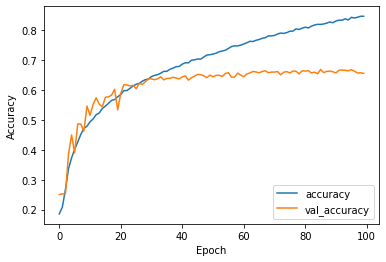

In [54]:
plt.plot(historyc.history['accuracy'], label='accuracy')
plt.plot(historyc.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


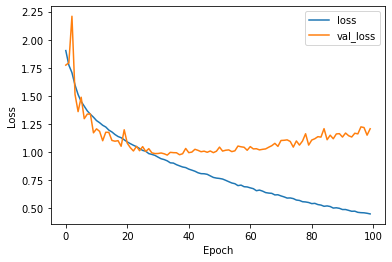

In [55]:
plt.plot(historyc.history['loss'], label='loss')
plt.plot(historyc.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

#Sources

https://www.kaggle.com/code/basel99/facial-recognition

https://www.tensorflow.org/tutorials/images/cnn

https://medium.com/themlblog/how-to-do-facial-emotion-recognition-using-a-cnn-b7bbae79cd8f

https://stackoverflow.com/questions/55776436/keras-cnn-model-is-not-learning


https://medium.com/@ml_kid/how-to-save-our-model-to-google-drive-and-reuse-it-2c1028058cb2